
IMPORT MODULES

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import mse_loss
import torchvision.models as models
import matplotlib.pyplot as plt
import random
import numpy as np
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)

if str(device) == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

Device is cuda


Variables global au modele

In [15]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 4
IMG_SIZE = 128
IMG_LAYER_DEPTH = 12

CPOOL_SIZE = 1024

In [16]:
cnn = models.vgg19(weights="IMAGENET1K_V1").features.to(device)
cnn.requires_grad_(False)

# Initialize outputs dic
outputs = {}

# Hook definition


def save_output(name):

    # The hook signature
    def hook(module, module_in, module_out) -> None:
        outputs[name] = module_out

    return hook


# Define layers
layers = [1, 6, 11, 20, 29]
# Define weights for layers
layers_weights = [1 / n**2 for n in [64, 128, 256, 512, 512]]

# Register hook on each layer with index on array "layers"
for layer in layers:
    handle = cnn[layer].register_forward_hook(save_output(layer))


def gramm(tnsr: torch.Tensor) -> torch.Tensor:
    # Computes Gram matrix for the input batch tensor.
    #    Args: tnsr (torch.Tensor): input tensor of the Size([B, C, H, W]).
    #    Returns:  G (torch.Tensor): output tensor of the Size([B, C, C]).
    b, c, h, w = tnsr.size()
    F = tnsr.view(b, c, h * w)
    G = torch.bmm(F, F.transpose(1, 2))
    G.div_(h * w)
    return G


def gram_loss(input: torch.Tensor, gramm_target: torch.Tensor, weight: float = 1.0):
    # Computes MSE Loss for 2 Gram matrices
    return weight * mse_loss(gramm(input), gramm_target)

Image target : préparation et calcul des gramm targets pour les layers prédefinit

[[[0.09019606 0.1529412  0.21960786]
  [0.09803919 0.16078433 0.227451  ]
  [0.09411763 0.15686277 0.22352943]
  ...
  [0.04705881 0.13725492 0.19215688]
  [0.04705881 0.13725492 0.19215688]
  [0.04705881 0.13725492 0.19215688]]

 [[0.10196076 0.17254904 0.25490198]
  [0.09411763 0.16078433 0.24705884]
  [0.09411763 0.1647059  0.24705884]
  ...
  [0.04705881 0.13725492 0.19215688]
  [0.03921567 0.12941179 0.18431374]
  [0.0352941  0.12549022 0.18039218]]

 [[0.4509804  0.5294118  0.6313726 ]
  [0.4509804  0.5254902  0.6313726 ]
  [0.4509804  0.5294118  0.6313726 ]
  ...
  [0.03921567 0.12941179 0.18431374]
  [0.0352941  0.12549022 0.18039218]
  [0.03137253 0.12156862 0.17647061]]

 ...

 [[0.12156861 0.20000002 0.28235295]
  [0.11372547 0.18823531 0.27058825]
  [0.10588233 0.18039218 0.27058825]
  ...
  [0.47058824 0.5647059  0.68235296]
  [0.4745098  0.5686275  0.6862745 ]
  [0.47843137 0.57254905 0.6901961 ]]

 [[0.45882353 0.5372549  0.63529414]
  [0.44705883 0.52156866 0.627451  ]


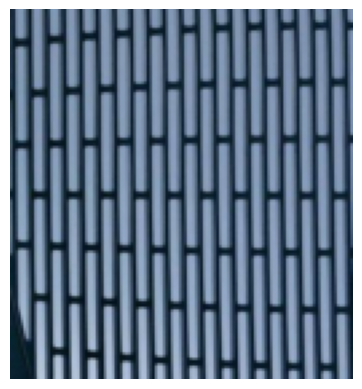

In [17]:
input_image_name = "grid_0124.jpg"  # à valeur dans 0-1 ...

# Prepare texture data
target = prep_img_file(input_image_name, IMG_SIZE).to(device)  # à valeur dans 0-1

# Forward pass using target texture for get activations of selected layers (outputs). Calculate gram Matrix for those activations
cnn(target / 0.25)
gramm_targets = [gramm(outputs[key]) for key in layers]

plt.axis("off")
plt.imshow(to_img(target))

In [18]:
def loss(img):
    # img : batch de 4 images de taille 12x128x128

    total_loss = 0
    # return torch.linalg.norm(img)

    # Prepare texture data
    synth = []
    for i in range(4):
        synth.append(img[i][:3].unsqueeze(0))

    # Forward pass using target texture for get activations of selected layers (outputs). Calculate gram Matrix for those activations
    for x in synth:
        losses = []
        cnn(x / 0.25)
        synth_outputs = [outputs[key] for key in layers]
        # calcul des loss pour toutes les couches

        for activations in zip(synth_outputs, gramm_targets, layers_weights):
            losses.append(gram_loss(*activations).unsqueeze(0))

        total_loss += torch.cat(losses).sum()

    return total_loss

Fonction qui construit un DataLoader avec en entrée un train data

Neural network


In [19]:
class RecursiveNN(nn.Module):
    def __init__(self):
        super(RecursiveNN, self).__init__()  # quece que ça fait cette merde ?

        self.ident = torch.tensor(
            [[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]
        ).to(device)
        self.sobel_x = torch.tensor(
            [[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]]
        ).to(device)
        self.lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]]).to(
            device
        )

        self.cn1 = nn.Conv2d(
            4 * IMG_LAYER_DEPTH, 96, kernel_size=1, padding=0, stride=1
        ).to(
            device
        )  # les biais ?  sont intégrés nn ?
        self.cn2 = nn.Conv2d(
            96, IMG_LAYER_DEPTH, kernel_size=1, padding=0, stride=1, bias=False
        ).to(device)

        self.cn1.weight.data.zero_()
        self.cn2.weight.data.zero_()

        self.cpool = torch.rand(
            size=(CPOOL_SIZE, IMG_LAYER_DEPTH, IMG_SIZE, IMG_SIZE), dtype=torch.float32
        ).to(
            device
        )  # 1028 images de 128x128

    def forward(self, x):
        """ "from the paper"""
        b, ch, h, w = x.shape
        filters = torch.stack([self.ident, self.sobel_x, self.sobel_x.T, self.lap]).to(
            device
        )

        y = x.reshape(b * ch, 1, h, w)
        y = torch.nn.functional.pad(y, [1, 1, 1, 1], "circular")
        y = torch.nn.functional.conv2d(y, filters[:, None])
        y = y.reshape(b, -1, h, w)

        """end of paper"""

        out = self.cn2(F.relu(self.cn1(y)))

        return out + x

    def render(model, it, width, height):

        x = torch.rand(
            size=(1, IMG_LAYER_DEPTH, width, height), dtype=torch.float32
        ).to(
            device
        )  # remplacer un des éléments du batch par une image rdm
        with torch.no_grad():
            for _ in range(0, it):
                x = model(x)
        return x

    def trainning(model, training_step):

        optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        model.train()  # met le modèle en mode entrainement je crois
        losses = []

        for i in range(1, training_step):

            indices = torch.randint(
                low=0, high=CPOOL_SIZE, size=(BATCH_SIZE,)
            )  # torch.randperm(len(model.cpool))[:4]
            x = model.cpool[indices]
            x[0] = torch.rand(
                size=(IMG_LAYER_DEPTH, 128, 128),
                dtype=torch.float32,
                requires_grad=False,
            ).to(device)  
            # remplacer un des éléments du batch par une image rdm

            x = x.clone()# .detach() # enlever le .detach casse tout

            niter = torch.randint(low=32, high=64, size=(1,))
            for _ in range(0, niter):
                x = model(x)

            L = loss(x)
            Ltot = L + torch.sum(torch.abs(x - x.clip(-1, 1))) / torch.numel(x)

            with torch.no_grad():
                Ltot.backward()
                for p in model.parameters():
                    p.grad /= p.grad.norm() + 1e-8  # normalize gradients
                optim.step()
                optim.zero_grad()

            # update dataloader
            model.cpool[indices] = x.detach()

            print(
                f"\rstep {i+1} / {training_step} | loss: {Ltot.item()} | val: [{torch.min(x)}, {torch.max(x)}] | L={L.item()}                        ",
                end="",
            )
            losses += [Ltot.cpu().detach().numpy()]
        print("\ntraining finished !")
        plt.semilogy(losses)

SETUP

TRAINNING

step 2000 / 2000 | loss: 0.004572788719087839 | val: [-1.1338047981262207, 1.12757408618927] | L=0.004569105803966522                            
training finished !


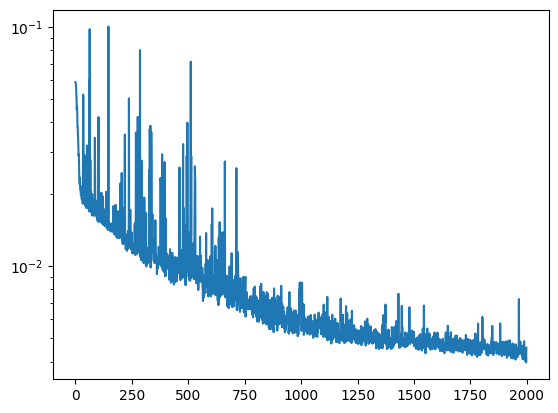

In [20]:
model = RecursiveNN()

model.trainning(2000)

RENDER

step 1000 / 1000 | loss: 0.0010801429161801934 | val: [-1.0819859504699707, 1.2857969999313354] | L=0.001078526140190661                        
training finished !


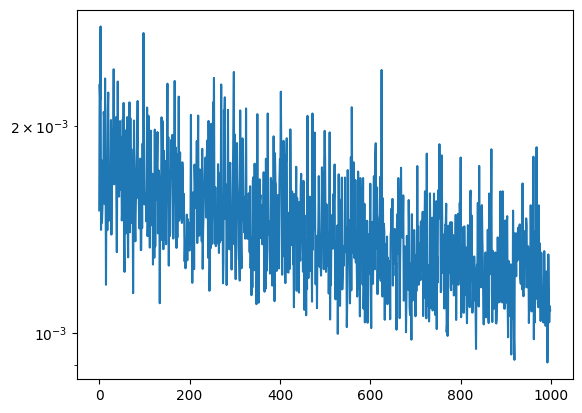

In [35]:
model.trainning(1000)

[[[0.19909663 0.         0.        ]
  [0.2975907  0.1739994  0.        ]
  [0.23056503 0.25513238 0.        ]
  ...
  [0.6899459  0.34967306 0.        ]
  [0.46736994 0.04210716 0.        ]
  [0.31750906 0.         0.        ]]

 [[0.21475513 0.         0.        ]
  [0.09853797 0.         0.        ]
  [0.03550975 0.         0.        ]
  ...
  [0.64147556 0.41402805 0.        ]
  [0.51845336 0.23575601 0.        ]
  [0.38048044 0.0455775  0.        ]]

 [[0.4195594  0.33500156 0.12886678]
  [0.23765531 0.21137385 0.02177547]
  [0.2505885  0.27761507 0.14421056]
  ...
  [0.60859233 0.5177741  0.1852306 ]
  [0.530978   0.40417105 0.14442016]
  [0.45921654 0.3187732  0.11127932]]

 ...

 [[0.4292703  0.4814096  0.68157095]
  [1.         1.         1.        ]
  [1.         0.9971791  1.        ]
  ...
  [0.94346297 0.5933243  0.64690024]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.4389998  0.21258129 0.2270454 ]
  [1.         1.         1.        ]


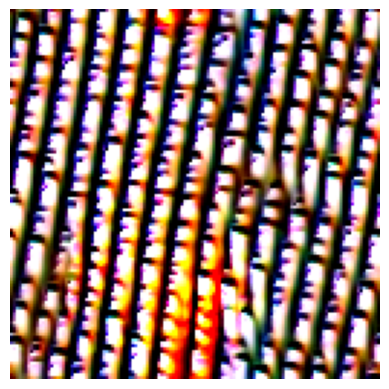

In [38]:
finish = model.render(50000, width=128, height=128)

plt.axis("off")
plt.imshow(to_img(finish))